## Imports

In [1]:
import os
import json
import pandas as pd
from fnmatch import fnmatch
from pathlib import Path
from os.path import basename
from pprint import pprint

import matplotlib.pyplot as plt

## Load Evaluation Results

In [2]:
eval_results_datasets_dict = dict()
for dataset in os.listdir('../models_datasets'):
    eval_results_dataset_dict = dict()
    for root_dir, sub_dir, file_names in os.walk('../models_datasets/' + dataset):
        for file_name in file_names:
            if fnmatch(file_name, 'evaluation_results.json'):
                file_path = os.path.join(root_dir, file_name)
                model_name = basename(Path(file_path).parent).split('hold_all_')[-1]
                #print(model_name)

                with open(file_path, 'r') as fp:
                    eval_results = json.load(fp)
                    #pprint(eval_results)                
                    eval_results_dataset_dict[model_name] = eval_results
    eval_results_datasets_dict[dataset] = eval_results_dataset_dict

# eval_results_datasets_dict

In [3]:
no_of_items_to_recommend = 10

datasets_eval_results = []
for dataset in eval_results_datasets_dict:
    eval_results_dataset_dict = eval_results_datasets_dict[dataset]
    dataset_eval = dict()
    dataset_eval['dataset'] = dataset
    for model in eval_results_dataset_dict:
        #print(dataset)
        eval_metrics = eval_results_dataset_dict[model]['no_of_items_to_recommend'][str(no_of_items_to_recommend)]
        
        for eval_metric, score in eval_metrics.items():
            model_eval_metric = model + '_' + eval_metric
            # print(model_eval_metric, score)
            dataset_eval[model_eval_metric] = score
    datasets_eval_results.append(dataset_eval)
datasets_eval_results_df = pd.DataFrame(datasets_eval_results)
# datasets_eval_results_df

In [4]:
datasets_eval_results_df.sort_values('dataset', inplace=True)

In [5]:
dataset_quarters_dict = {
    'dataset_1' : '2016Q2',
    'dataset_2' : '2016Q3',
    'dataset_3' : '2016Q4',
    'dataset_4' : '2017Q1',
}
datasets_eval_results_df['quarter'] = datasets_eval_results_df['dataset'].map(dataset_quarters_dict)
datasets_eval_results_df.head()

,content_based_avg_f1_score,content_based_avg_fpr,content_based_avg_mcc_score,content_based_avg_precision,content_based_avg_recall,content_based_avg_tpr,dataset,item_based_cf_avg_f1_score,item_based_cf_avg_fpr,item_based_cf_avg_mcc_score,...,random_based_avg_precision,random_based_avg_recall,random_based_avg_tpr,user_based_cf_avg_f1_score,user_based_cf_avg_fpr,user_based_cf_avg_mcc_score,user_based_cf_avg_precision,user_based_cf_avg_recall,user_based_cf_avg_tpr,quarter
3,0.0010,0.0003,0.0009,0.0035,0.0007,0.0007,dataset_1,0.0011,0.0011,0.0001,...,0.0025,0.0035,0.0035,0.0025,0.0010,0.0019,0.0068,0.0041,0.0041,2016Q2
2,0.0006,0.0006,0.0003,0.0007,0.0005,0.0005,dataset_2,0.0027,0.0036,0.0006,...,0.0006,0.0012,0.0012,0.0065,0.0030,0.0054,0.0085,0.0130,0.0130,2016Q3
1,0.0000,0.0004,-0.0002,0.0000,0.0000,0.0000,dataset_3,0.0052,0.0035,0.0043,...,0.0007,0.0022,0.0022,0.0077,0.0028,0.0077,0.0082,0.0177,0.0177,2016Q4
0,0.0007,0.0005,0.0008,0.0004,0.0022,0.0022,dataset_4,0.0027,0.0034,0.0013,...,0.0001,0.0007,0.0007,0.0047,0.0028,0.0040,0.0037,0.0104,0.0104,2017Q1


## Plot Evaluation Results

In [6]:
def get_eval_results(metric):
    #metric_cols = ['dataset']
    metric_cols = ['quarter']
    for col in datasets_eval_results_df.columns:
        if metric in col:
            metric_cols.append(col)
    return datasets_eval_results_df[metric_cols]

def plot_eval_results(metric):
    metric_df = get_eval_results(metric)
    for col in metric_df.columns:
        #if col == 'dataset':
        #    continue
        if col == 'quarter':
            continue
        model_name, metric = col.split('_avg_')
        #plt.plot('dataset', col, data=metric_df, marker='o', label=model_name)
        plt.plot('quarter', col, data=metric_df, marker='o', label=model_name)
    plt.legend()  
    #plt.xlabel('Datasets')
    plt.xlabel('Quarter')
    plt.ylabel(metric)
    plt.show()

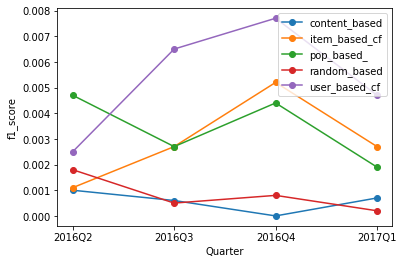

In [7]:
plot_eval_results('f1_score')

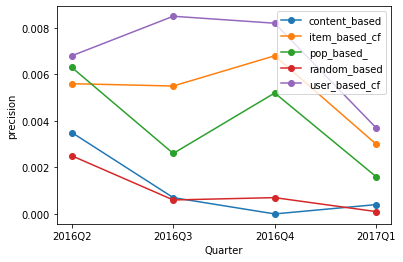

In [8]:
plot_eval_results('precision')

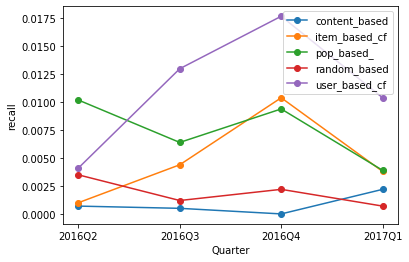

In [9]:
plot_eval_results('recall')

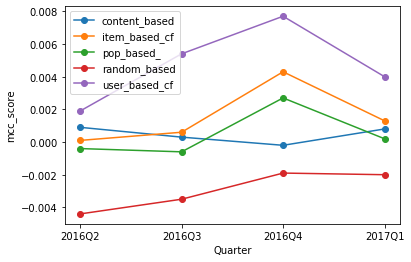

In [10]:
plot_eval_results('mcc')

In [11]:
def get_roc2_results():
    #metric_cols = ['dataset']
    metric_cols = ['quarter']
    for col in datasets_eval_results_df.columns:
        if 'tpr' in col or 'fpr' in col:
            metric_cols.append(col)
    return datasets_eval_results_df[metric_cols]

def plot_roc2_results():
    metric_df = get_roc2_results()
    model_tpr_fpr = dict()
    for col in metric_df.columns:     
        if col == 'quarter':
            continue
        model_name, metric = col.split('_avg_')
        if model_name not in model_tpr_fpr:
            model_tpr_fpr[model_name] = dict()
        temp = pd.DataFrame(metric_df[['quarter', col]]).set_index('quarter').to_dict()
        model_tpr_fpr[model_name][metric] = temp[col]
    #pprint(model_tpr_fpr)
    for model in model_tpr_fpr:     
        plt.plot(list(model_tpr_fpr[model]['fpr'].values()), list(model_tpr_fpr[model]['tpr'].values()), 
                 marker='o', label=model)    
    plt.legend()  
    plt.title('ROC2')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')    
    plt.show()

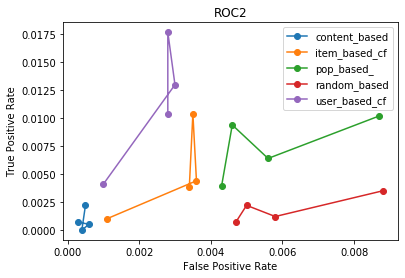

In [12]:
plot_roc2_results()